In [1]:
!pip install pygame
!pip install gym==0.26.2
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 KB 25.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827648 sha256=88e306b9c1b40d948c8944b355106cfe4342efb436999ca452e4205b3e322f3f
  Stored in directory: /root/.cache/pip/wheels/af/2b/30/5e78b8b9599f2a2286a582b8da80594f654bf0e18d825a4405
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency con

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordEpisodeStatistics
gymlogger.set_level(40) #error only
from torch import nn
import torch
from torch.nn import functional as F
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from base64 import b64encode
from collections import namedtuple, deque
from itertools import count
import torch.optim as optim

from IPython import display as ipythondisplay
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [3]:
gym.__version__

'0.26.2'

In [4]:
env = gym.make('LunarLander-v2', render_mode = "rgb_array")

In [10]:
state, info = env.reset()
env.action_space.sample()
print(state)
print(info)
print(env.action_space.n)

[ 0.00327988  1.4000981   0.33219883 -0.48097566 -0.00379375 -0.07524793
  0.          0.        ]
{}
4


In [5]:
!nvidia-smi

Wed Apr  5 07:58:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

  def __init__(self, capacity):
    self.memory = deque([], maxlen=capacity)

  def push(self, *args):
    """Save a transition"""
    self.memory.append(Transition(*args))

  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)

  def __len__(self):
    return len(self.memory)

In [7]:
class DQN(nn.Module):

  def __init__(self, n_observations, n_actions):
    super(DQN, self).__init__()
    self.layer1 = nn.Linear(n_observations, 128)
    self.layer2 = nn.Linear(128, 128)
    self.layer3 = nn.Linear(128, n_actions)

  # Called with either one element to determine next action, or a batch
  # during optimization. Returns tensor([[left0exp,right0exp]...]).
  def forward(self, x):
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    return self.layer3(x)

In [8]:
class Agent:
  def __init__(self, env, BATCH_SIZE=128, GAMMA=0.99, EPS_START=0.9, EPS_END=0.05,
               EPS_DECAY=1000, TAU=0.005, LR=1e-4, use_double_DQN=False, memory_size=10000):
    self.env = env
    self.BATCH_SIZE = BATCH_SIZE
    self.GAMMA = GAMMA
    self.EPS_START = EPS_START
    self.EPS_END = EPS_END
    self.EPS_DECAY = EPS_DECAY
    self.TAU = TAU
    self.use_double_DQN = use_double_DQN
    self.n_actions = env.action_space.n
    state, info = env.reset()
    self.n_observations = len(state)
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.policy_net = DQN(self.n_observations, self.n_actions).to(self.device)
    self.target_net = DQN(self.n_observations, self.n_actions).to(self.device)
    self.target_net.load_state_dict(self.policy_net.state_dict())
    self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=LR, amsgrad=True)
    self.memory = ReplayMemory(memory_size)
    self.steps_done = 0

  def select_action(self, state, is_test):
    sample = random.random()
    eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
        math.exp(-1. * self.steps_done / self.EPS_DECAY)
    self.steps_done += 1
    if sample > eps_threshold or is_test==True:
      with torch.no_grad():
        # t.max(1) will return the largest column value of each row.
        # second column on max result is index of where max element was
        # found, so we pick action with the larger expected reward.
        return self.policy_net(state).max(1)[1].view(1, 1)
    else:
      return torch.tensor([[self.env.action_space.sample()]], device=self.device, dtype=torch.long)
  
  def optimize_model(self):
    if len(self.memory) < self.BATCH_SIZE:
        return
    transitions = self.memory.sample(self.BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=self.device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    # 1 is column, action_batch is index
    # get the state_action_value
    # https://zhuanlan.zhihu.com/p/352877584
    state_action_values = self.policy_net(state_batch).gather(1, action_batch)
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final. 0 is value, 1 is indices
    next_state_values = torch.zeros(self.BATCH_SIZE, device=self.device)
    
    #double-DQN
    if(self.use_double_DQN):
      with torch.no_grad():
        non_final_next_state_action_batch = self.policy_net(non_final_next_states).max(1)[1].unsqueeze(1)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).gather(1, non_final_next_state_action_batch).flatten()
    else:
    #DQN
      with torch.no_grad():
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]


    # Compute the expected Q values
    expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    self.optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
    self.optimizer.step()
  
  def update_network(self):
    # Soft update of the target network's weights
    # θ′ ← τ θ + (1 −τ )θ′
    target_net_state_dict = self.target_net.state_dict()
    policy_net_state_dict = self.policy_net.state_dict()
    for key in policy_net_state_dict:
      target_net_state_dict[key] = policy_net_state_dict[key]*self.TAU + target_net_state_dict[key]*(1-self.TAU)
    self.target_net.load_state_dict(target_net_state_dict)


In [20]:
def train_model(agent, env):
  if torch.cuda.is_available():
    num_episodes = 500
  else:
    num_episodes = 50

  reward_list = []

  for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=agent.device).unsqueeze(0)
    temp_reward = 0
    for t in count():
      action = agent.select_action(state, False)
      observation, reward, terminated, truncated, _ = env.step(action.item())
      temp_reward += reward
      reward = torch.tensor([reward], device=agent.device)
      done = terminated or truncated

      if terminated:
        next_state = None
      else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=agent.device).unsqueeze(0)

      # Store the transition in memory
      agent.memory.push(state, action, next_state, reward)

      # Move to the next state
      state = next_state

      # Perform one step of the optimization (on the policy network)
      agent.optimize_model()

      agent.update_network()

      if done:
        reward_list.append(temp_reward)
        if(i_episode+1)%10 == 0:
          print(f'已经完成{i_episode+1}代')
        break

  print('Complete')
  return reward_list

In [12]:
def draw_pic(x, y, path):
    plt.plot(x, y)
    plt.xlabel("iteration")
    plt.ylabel("reward")
    plt.savefig(path)

已经完成10代
已经完成20代
已经完成30代
已经完成40代
已经完成50代
已经完成60代
已经完成70代
已经完成80代
已经完成90代
已经完成100代
已经完成110代
已经完成120代
已经完成130代
已经完成140代
已经完成150代
已经完成160代
已经完成170代
已经完成180代
已经完成190代
已经完成200代
已经完成210代
已经完成220代
已经完成230代
已经完成240代
已经完成250代
已经完成260代
已经完成270代
已经完成280代
已经完成290代
已经完成300代
已经完成310代
已经完成320代
已经完成330代
已经完成340代
已经完成350代
已经完成360代
已经完成370代
已经完成380代
已经完成390代
已经完成400代
已经完成410代
已经完成420代
已经完成430代
已经完成440代
已经完成450代
已经完成460代
已经完成470代
已经完成480代
已经完成490代
已经完成500代
Complete


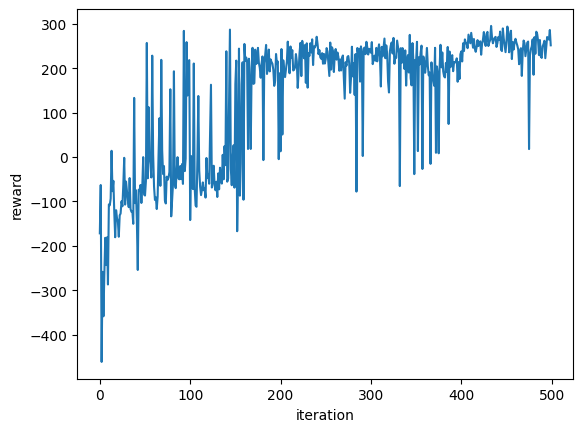

In [21]:
env.reset()
double_dqn = Agent(env, use_double_DQN=True)
double_DQN_reward = train_model(double_dqn, env)
draw_pic(range(len(double_DQN_reward)), double_DQN_reward,'iteration-reward')

In [22]:
torch.save(double_dqn.policy_net.state_dict(), "./model_parameter.pkl")

In [38]:
env = gym.make('LunarLander-v2', render_mode = "rgb_array")

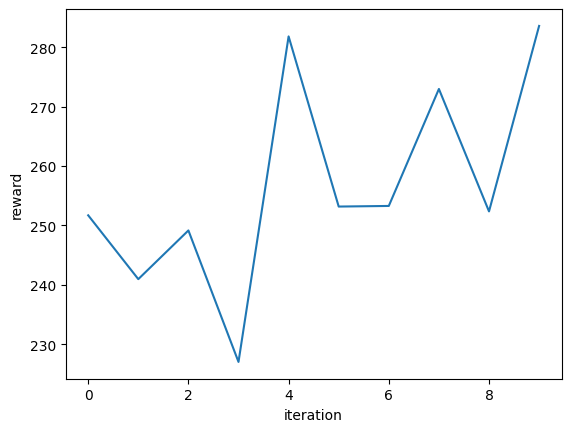

In [39]:
#test
test_reward_list = []
for i in range(10):
  state, info = env.reset()
  state = torch.tensor(state, dtype=torch.float32, device=double_dqn.device).unsqueeze(0)
  temp_reward = 0
  for t in count():
    action = double_dqn.select_action(state, True)
    observation, reward, terminated, truncated, _ = env.step(action.item())
    temp_reward += reward
    done = terminated or truncated
    state = torch.tensor(observation, dtype=torch.float32, device=double_dqn.device).unsqueeze(0)
    if done:
      test_reward_list.append(temp_reward)
      break
draw_pic(range(len(test_reward_list)), test_reward_list, "iteration-Reward-test")

In [45]:
def show_video(episode):
  mp4 = open(f'./Lunar-episode-{episode}.mp4','rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  ipythondisplay.display(HTML("""
  <video width=400 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url))

In [53]:
from gym import wrappers
env = gym.make('LunarLander-v2', render_mode = "rgb_array")
env = wrappers.RecordVideo(env, video_folder='./',name_prefix='Lunar')
state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=double_dqn.device).unsqueeze(0)
temp_reward = 0
for t in count():
  action = double_dqn.select_action(state, True)
  observation, reward, terminated, truncated, _ = env.step(action.item())
  temp_reward += reward
  done = terminated or truncated
  state = torch.tensor(observation, dtype=torch.float32, device=double_dqn.device).unsqueeze(0)
  if done:
    print(temp_reward)
    break
show_video(0)

Moviepy - Building video /content/Lunar-episode-0.mp4.
Moviepy - Writing video /content/Lunar-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/Lunar-episode-0.mp4
258.43279084190567
